# Bibliotecas

In [1]:
# Data manipulation

import pandas as pd
import numpy as np

# Data viz

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtenção dos dados

In [2]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [3]:
# !kaggle datasets download -d ahmedabbas757/coffee-sales -p data --unzip

# 2. Importação dos dados

In [4]:
data = pd.read_excel('data/Coffee Shop Sales.xlsx')

In [5]:
print(f'Linhas: {data.shape[0]}')
print(f'Colunas: {data.shape[1]}')

Linhas: 149116
Colunas: 11


In [6]:
data.head(3)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg


# 3. Inspeção geral dos dados

| **Variável**            | **Descrição**                                                                                   |
|------------------------|-----------------------------------------------------------------------------------------------|
| **transaction_id**     | ID sequencial único representando uma transação individual                                    |
| **transaction_date**   | Data da transação (MM/DD/YY)                                                                  |
| **transaction_time**   | Horário da transação (HH:MM:SS)                                                               |
| **transaction_qty**    | Quantidade de itens vendidos                                                                  |
| **store_id**           | ID único da cafeteria onde a transação ocorreu                                               |
| **store_location**     | Localização da cafeteria onde a transação ocorreu                                            |
| **product_id**         | ID único do produto vendido                                                                  |
| **unit_price**         | Preço de varejo do produto vendido                                                           |
| **product_category**   | Descrição da categoria do produto                                                            |
| **product_type**       | Descrição do tipo de produto                                                                 |
| **product_detail**     | Descrição do detalhe do produto                                                              |


# 4.Split dos dados

`Observação`: Como o projeto envolve séries temporais, é essencial que os conjuntos de treino e teste sejam divididos com base no tempo, preservando a ordem cronológica dos dados. Seleções aleatórias podem causar vazamento de informações, uma vez que dados futuros poderiam influenciar a previsão de eventos passados.

In [7]:
# Exploração do ponto de corte (data)
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['transaction_date'].dt.to_period('M').unique()

<PeriodArray>
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06']
Length: 6, dtype: period[M]

Os dados disponíveis correspondem a 6 meses de vendas da cafeteria. O objetivo é usar esses dados para prever o desempenho do mês mais recente.

In [16]:
# Ponto de corte
train_end_date = '2023-04-30'

In [17]:
# Criando os conjuntos de treino e teste
train = data[data['transaction_date'] <= train_end_date]
test = data[data['transaction_date'] > train_end_date]

print(f'Linhas do treino {train.shape[0]}')
print(f'Linhas do teste {test.shape[0]}')

Linhas do treino 80237
Linhas do teste 68879


# 5. EDA

In [41]:
train

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
...,...,...,...,...,...,...,...,...,...,...,...
80232,80406,2023-04-30,19:58:35,1,3,Astoria,37,3.00,Coffee,Barista Espresso,Espresso shot
80233,80407,2023-04-30,20:32:15,2,8,Hell's Kitchen,33,3.50,Coffee,Gourmet brewed coffee,Ethiopia Lg
80234,80408,2023-04-30,20:52:03,1,8,Hell's Kitchen,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
80235,80409,2023-04-30,20:57:11,2,8,Hell's Kitchen,60,3.75,Drinking Chocolate,Hot chocolate,Sustainably Grown Organic Rg


# 6. Split temporal

In [43]:
df = train.copy()

In [24]:
df['ref_date'] = df['transaction_date'].apply(lambda x: str(x)[:7])

In [34]:
df_grouped = df.groupby('transaction_date').agg({'unit_price':'sum', 'transaction_id':'count'})

In [44]:
# Agrupado por dia
df_grouped

,unit_price,transaction_id
transaction_date,,
2023-01-01,1731.80,550
2023-01-02,1743.95,566
2023-01-03,1826.60,582
2023-01-04,1533.40,497
2023-01-05,1715.35,547
...,...,...
2023-04-26,3146.10,915
2023-04-27,2931.15,954
2023-04-28,2382.45,769


<Axes: xlabel='transaction_date'>

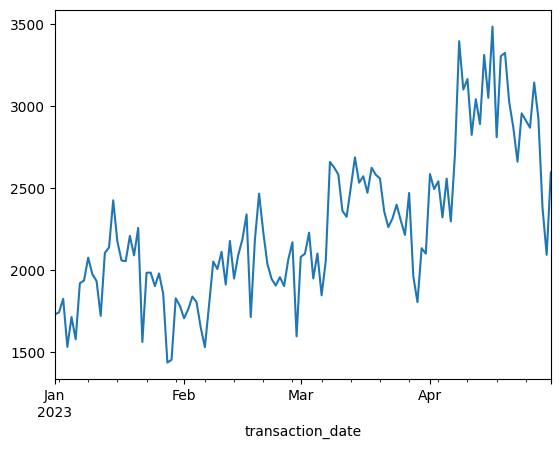

In [36]:
df_grouped['unit_price'].plot()

In [38]:
# Separando features e target dos dados de treino e de teste

# X_train = train.drop('unit_price',axis=1)
# y_train = train['unit_price']

# X_test = test.drop('unit_price',axis=1)
# y_test = test['unit_price']

# 7. Feature engineering